# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [83]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [84]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2024, 11, 18, 18, 2, 16, 144397)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [85]:
# If you haven't set the env variable 'HOPSWORKS_API_KEY', then uncomment the next line and enter your API key
# os.environ["HOPSWORKS_API_KEY"] = ""
#with open('../../data/hopsworks-api-key.txt', 'r') as file:
#    os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()

project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1159325
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [86]:
#feature_view = fs.get_feature_view(
#    name='air_quality_fv',
#    version=1,
#)
feature_view = fs.get_feature_view(
    name='air_quality_with_lag_fv',
    version=1,
)


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [95]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model_with_lag",
    version=7,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [96]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='1.9824781E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [97]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
# batch_data.iloc[1]
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.12s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2024-11-19 00:00:00+00:00,-3.70,0.0,26.474077,22.380184,reykjavik
1,2024-11-20 00:00:00+00:00,-4.05,0.0,27.009598,21.092421,reykjavik
2,2024-11-21 00:00:00+00:00,-7.45,0.0,8.121970,77.195740,reykjavik
3,2024-11-22 00:00:00+00:00,-5.70,0.0,8.287822,55.619598,reykjavik
4,2024-11-23 00:00:00+00:00,-4.40,0.0,9.178235,64.440094,reykjavik
5,2024-11-24 00:00:00+00:00,-6.50,0.0,10.495713,22.166399,reykjavik
6,2024-11-25 00:00:00+00:00,-4.20,0.0,7.704336,142.594574,reykjavik
7,2024-11-26 00:00:00+00:00,0.05,0.0,15.990646,148.815079,reykjavik
8,2024-11-27 00:00:00+00:00,3.35,0.3,33.518684,114.087448,reykjavik


In [98]:
### Get PM25 history 
air_quality_with_lag_fg = fs.get_feature_group(
    name='air_quality_with_3day_lag',
    version=1,
)
aq_yesterday_df = air_quality_with_lag_fg.read().sort_values(by='date').tail(1)
aq_yesterday_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.36s) 


,date,pm25,pm25_lag_1,pm25_lag_2,pm25_lag_3,country,city,street,url
1448,2024-11-18 00:00:00+00:00,22.0,11.0,13.0,23.0,iceland,reykjavik,husdyragardurinn,http://api.waqi.info/feed/iceland/husdyrag.


In [99]:
#### Using lag, predict one at a time, and use for next prediction 

### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [129]:
#batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
#    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
forcast_days = batch_data.shape[0]

lag1 = aq_yesterday_df['pm25_lag_1'].values[0]
lag2 = aq_yesterday_df['pm25_lag_2'].values[0]
lag3 = aq_yesterday_df['pm25_lag_3'].values[0]

# Go one by one 
for i in range(forcast_days):

    # Get the weather features values for day i 
    weather_features = batch_data.iloc[i][['temperature_2m_mean', 'precipitation_sum','wind_speed_10m_max', 'wind_direction_10m_dominant']].values
    # Combine with lag values
    features = list(weather_features) + [lag1, lag2, lag3]

    print(f"Day {i + 1} input features: {features}")

    predicted_pm25 = retrieved_xgboost_model.predict([features])[0]

    #predicted_pm25 = float(round(predicted_pm25, i)) # same form as the data ? 
    #predicted_pm25 = max(0, predicted_pm25)  # dont allow below 0 ? 
    print(predicted_pm25)

    batch_data.at[i, 'predicted_pm25'] = predicted_pm25

    # Now update the lag 
    lag3 = lag2
    lag2 = lag1
    lag1 = predicted_pm25

# Fix float issue
batch_data['predicted_pm25'] = batch_data['predicted_pm25'].astype('float32')

batch_data


Day 1 input features: [-3.7, 0.0, 26.474077, 22.380184, 11.0, 13.0, 23.0]
7.8325996
Day 2 input features: [-4.05, 0.0, 27.009598, 21.09242, 7.8325996, 11.0, 13.0]
8.327611
Day 3 input features: [-7.45, 0.0, 8.12197, 77.19574, 8.327611, 7.8325996, 11.0]
1.9031451
Day 4 input features: [-5.7, 0.0, 8.287822, 55.6196, 1.9031451, 8.327611, 7.8325996]
2.4023647
Day 5 input features: [-4.4, 0.0, 9.178235, 64.440094, 2.4023647, 1.9031451, 8.327611]
2.4638152
Day 6 input features: [-6.5, 0.0, 10.495713, 22.166399, 2.4638152, 2.4023647, 1.9031451]
8.189685
Day 7 input features: [-4.2, 0.0, 7.7043357, 142.59457, 8.189685, 2.4638152, 2.4023647]
6.2177563
Day 8 input features: [0.05, 0.0, 15.990646, 148.81508, 6.2177563, 8.189685, 2.4638152]
6.531076
Day 9 input features: [3.35, 0.3, 33.518684, 114.08745, 6.531076, 6.2177563, 8.189685]
11.196088


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-19 00:00:00+00:00,-3.70,0.0,26.474077,22.380184,reykjavik,7.832600,husdyragardurinn,iceland,1
1,2024-11-20 00:00:00+00:00,-4.05,0.0,27.009598,21.092421,reykjavik,8.327611,husdyragardurinn,iceland,2
2,2024-11-21 00:00:00+00:00,-7.45,0.0,8.121970,77.195740,reykjavik,1.903145,husdyragardurinn,iceland,3
3,2024-11-22 00:00:00+00:00,-5.70,0.0,8.287822,55.619598,reykjavik,2.402365,husdyragardurinn,iceland,4
4,2024-11-23 00:00:00+00:00,-4.40,0.0,9.178235,64.440094,reykjavik,2.463815,husdyragardurinn,iceland,5
5,2024-11-24 00:00:00+00:00,-6.50,0.0,10.495713,22.166399,reykjavik,8.189685,husdyragardurinn,iceland,6
6,2024-11-25 00:00:00+00:00,-4.20,0.0,7.704336,142.594574,reykjavik,6.217756,husdyragardurinn,iceland,7
7,2024-11-26 00:00:00+00:00,0.05,0.0,15.990646,148.815079,reykjavik,6.531076,husdyragardurinn,iceland,8
8,2024-11-27 00:00:00+00:00,3.35,0.3,33.518684,114.087448,reykjavik,11.196088,husdyragardurinn,iceland,9


In [130]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   predicted_pm25               9 non-null      float32            
 7   street                       9 non-null      object             
 8   country                      9 non-null      object             
 9   days_before_forecast_day     9 non-null      int64              
dtypes: datetime64[us, UTC](1), float32(5), int64(1), objec

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [131]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)

batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-19 00:00:00+00:00,-3.70,0.0,26.474077,22.380184,reykjavik,7.832600,husdyragardurinn,iceland,1
1,2024-11-20 00:00:00+00:00,-4.05,0.0,27.009598,21.092421,reykjavik,8.327611,husdyragardurinn,iceland,2
2,2024-11-21 00:00:00+00:00,-7.45,0.0,8.121970,77.195740,reykjavik,1.903145,husdyragardurinn,iceland,3
3,2024-11-22 00:00:00+00:00,-5.70,0.0,8.287822,55.619598,reykjavik,2.402365,husdyragardurinn,iceland,4
4,2024-11-23 00:00:00+00:00,-4.40,0.0,9.178235,64.440094,reykjavik,2.463815,husdyragardurinn,iceland,5
5,2024-11-24 00:00:00+00:00,-6.50,0.0,10.495713,22.166399,reykjavik,8.189685,husdyragardurinn,iceland,6
6,2024-11-25 00:00:00+00:00,-4.20,0.0,7.704336,142.594574,reykjavik,6.217756,husdyragardurinn,iceland,7
7,2024-11-26 00:00:00+00:00,0.05,0.0,15.990646,148.815079,reykjavik,6.531076,husdyragardurinn,iceland,8
8,2024-11-27 00:00:00+00:00,3.35,0.3,33.518684,114.087448,reykjavik,11.196088,husdyragardurinn,iceland,9


In [132]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   predicted_pm25               9 non-null      float32            
 7   street                       9 non-null      object             
 8   country                      9 non-null      object             
 9   days_before_forecast_day     9 non-null      int64              
dtypes: datetime64[us, UTC](1), float32(5), int64(1), objec

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

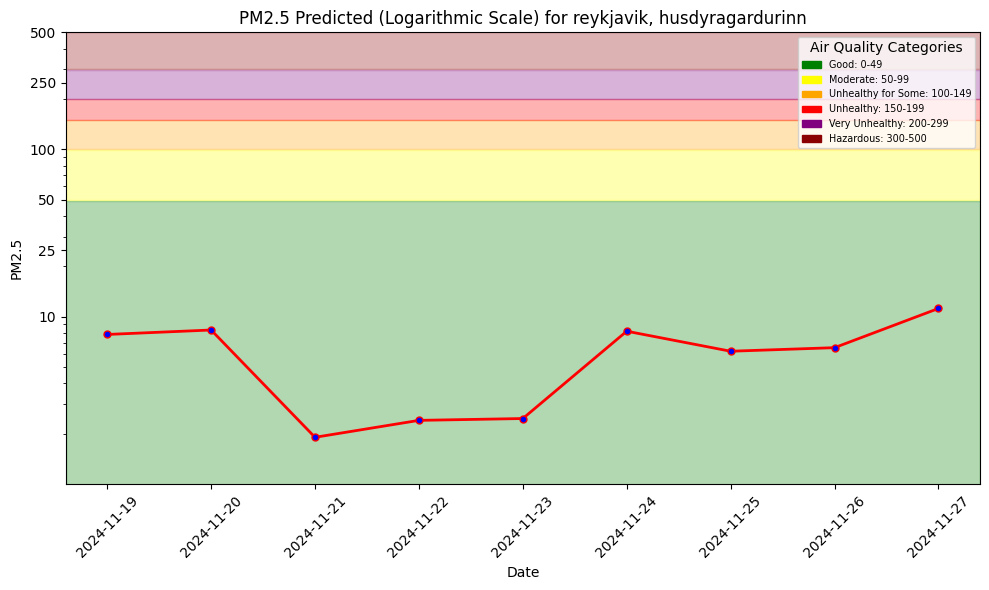

In [133]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [137]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [138]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 0.00% |          | Rows 0/9 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1159325/jobs/named/aq_predictions_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x18366e98810>, None)

In [139]:
# We will create a hindcast chart for only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.58s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-14 00:00:00+00:00,9.55,0.2,38.023907,198.778122,reykjavik,36.995037,husdyragardurinn,iceland,1
1,2024-11-08 00:00:00+00:00,6.90,0.0,24.291330,140.411896,reykjavik,19.278307,husdyragardurinn,iceland,1
2,2024-11-12 00:00:00+00:00,6.60,0.3,36.721764,217.431671,reykjavik,50.956795,husdyragardurinn,iceland,1
3,2024-11-15 00:00:00+00:00,1.90,0.4,47.852924,328.223114,reykjavik,71.640076,husdyragardurinn,iceland,1
4,2024-11-16 00:00:00+00:00,-0.50,0.0,26.019806,14.420815,reykjavik,28.114626,husdyragardurinn,iceland,1
5,2024-11-17 00:00:00+00:00,-3.30,0.0,22.596991,30.650600,reykjavik,22.092575,husdyragardurinn,iceland,1
6,2024-11-19 00:00:00+00:00,-3.70,0.0,26.474077,22.380184,reykjavik,7.832600,husdyragardurinn,iceland,1


In [140]:
#air_quality_fg = fs.get_feature_group(
#    name='air_quality',
#    version=1,
#)
air_quality_with_lag_fg = fs.get_feature_group(
    name='air_quality_with_3day_lag',
    version=1,
)
air_quality_df = air_quality_with_lag_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.25s) 


,date,pm25,pm25_lag_1,pm25_lag_2,pm25_lag_3,country,city,street,url
0,2023-11-27 00:00:00+00:00,5.0,10.0,7.0,12.0,iceland,reykjavik,husdyragardurinn,http://api.waqi.info/feed/iceland/husdyrag.
1,2024-09-26 00:00:00+00:00,8.0,8.0,15.0,10.0,iceland,reykjavik,husdyragardurinn,http://api.waqi.info/feed/iceland/husdyrag.
2,2015-08-18 00:00:00+00:00,30.0,34.0,25.0,38.0,iceland,reykjavik,husdyragardurinn,http://api.waqi.info/feed/iceland/husdyrag.
3,2016-11-13 00:00:00+00:00,36.0,31.0,23.0,24.0,iceland,reykjavik,husdyragardurinn,http://api.waqi.info/feed/iceland/husdyrag.
4,2024-07-10 00:00:00+00:00,15.0,14.0,11.0,15.0,iceland,reykjavik,husdyragardurinn,http://api.waqi.info/feed/iceland/husdyrag.
...,...,...,...,...,...,...,...,...,...
1608,2024-06-16 00:00:00+00:00,30.0,47.0,54.0,12.0,iceland,reykjavik,husdyragardurinn,http://api.waqi.info/feed/iceland/husdyrag.
1609,2016-08-22 00:00:00+00:00,38.0,27.0,45.0,35.0,iceland,reykjavik,husdyragardurinn,http://api.waqi.info/feed/iceland/husdyrag.
1610,2018-06-09 00:00:00+00:00,8.0,13.0,20.0,8.0,iceland,reykjavik,husdyragardurinn,http://api.waqi.info/feed/iceland/husdyrag.
1611,2023-09-17 00:00:00+00:00,20.0,7.0,9.0,10.0,iceland,reykjavik,husdyragardurinn,http://api.waqi.info/feed/iceland/husdyrag.


In [141]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

,date,predicted_pm25,pm25
1,2024-11-08 00:00:00+00:00,19.278307,18.0
2,2024-11-12 00:00:00+00:00,50.956795,44.0
0,2024-11-14 00:00:00+00:00,36.995037,14.0
3,2024-11-15 00:00:00+00:00,71.640076,27.0
4,2024-11-16 00:00:00+00:00,28.114626,23.0
5,2024-11-17 00:00:00+00:00,22.092575,13.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

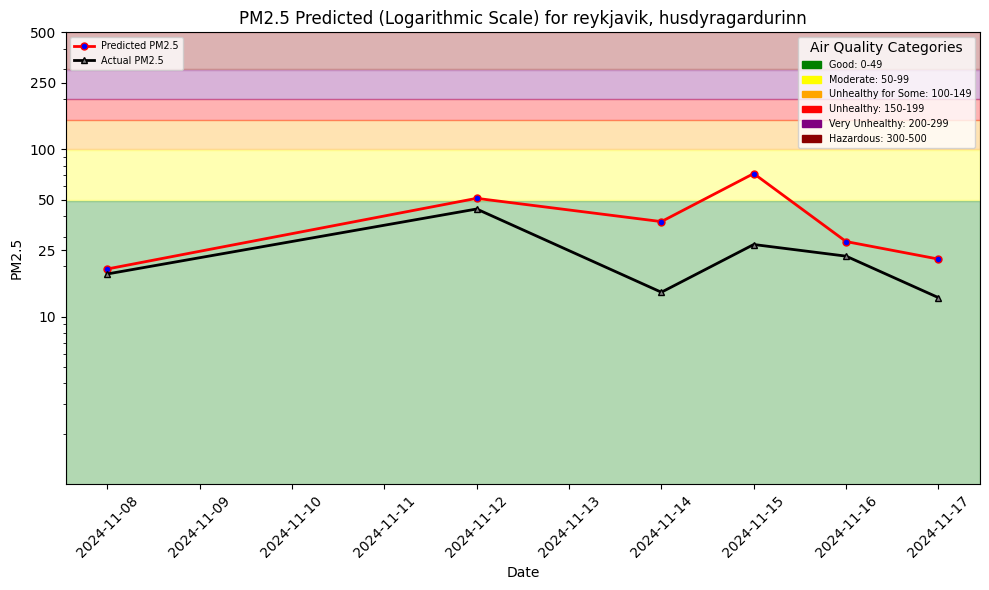

In [142]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---